<a href="https://colab.research.google.com/github/bijanideepak/CVIP-Java-Development/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.image as mpimg

In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [69]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1001 files belonging to 3 classes.


In [14]:
class_names = dataset.class_names
class_names

['Potato__Late_blight', 'Potato__bell_Bacteria', 'Potato__healthy']

In [15]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0]


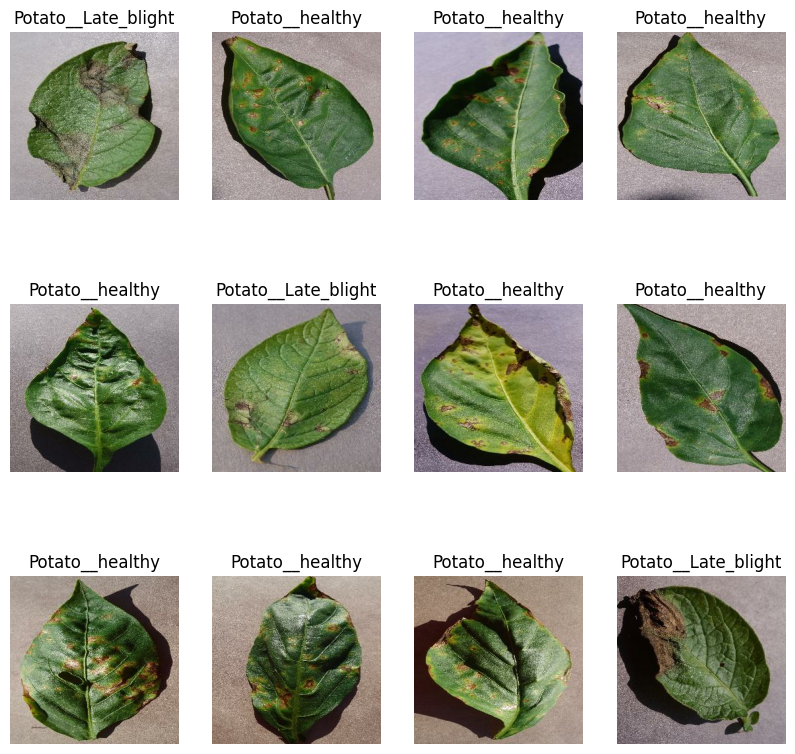

In [16]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [17]:
len(dataset)

32

In [18]:
train_size = 0.8
len(dataset)*train_size

25.6

In [19]:
train_ds = dataset.take(54)
len(train_ds)

32

In [20]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [21]:
val_size=0.1
len(dataset)*val_size

3.2

In [22]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [23]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [24]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [26]:
len(train_ds)

25

In [27]:
len(val_ds)

3

In [28]:
len(test_ds)

4

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
25/25 [==============================] - 201s 5s/step - loss: 0.6991 - accuracy: 0.7350 - val_loss: 0.5873 - val_accuracy: 0.7812
Epoch 2/50
25/25 [==============================] - 114s 5s/step - loss: 0.5841 - accuracy: 0.7550 - val_loss: 0.5409 - val_accuracy: 0.7812
Epoch 3/50
25/25 [==============================] - 113s 5s/step - loss: 0.4677 - accuracy: 0.7550 - val_loss: 0.7872 - val_accuracy: 0.7812
Epoch 4/50
25/25 [==============================] - 112s 5s/step - loss: 0.4717 - accuracy: 0.7900 - val_loss: 0.8993 - val_accuracy: 0.7812
Epoch 5/50
25/25 [==============================] - 113s 5s/step - loss: 0.4315 - accuracy: 0.7912 - val_loss: 0.6539 - val_accuracy: 0.7917
Epoch 6/50
25/25 [==============================] - 122s 5s/step - loss: 0.4141 - accuracy: 0.7987 - val_loss: 0.4351 - val_accuracy: 0.8333
Epoch 7/50
25/25 [==============================] - 114s 5s/step - loss: 0.3561 - accuracy: 0.8562 - val_loss: 0.7891 - val_accuracy: 0.7917
Epoch 8/50
25

In [37]:
history

In [38]:
type(history.history['loss'])

list

In [39]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 25}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

50

In [43]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6991302371025085,
 0.5840772390365601,
 0.4676693081855774,
 0.4717453122138977,
 0.4314894378185272]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

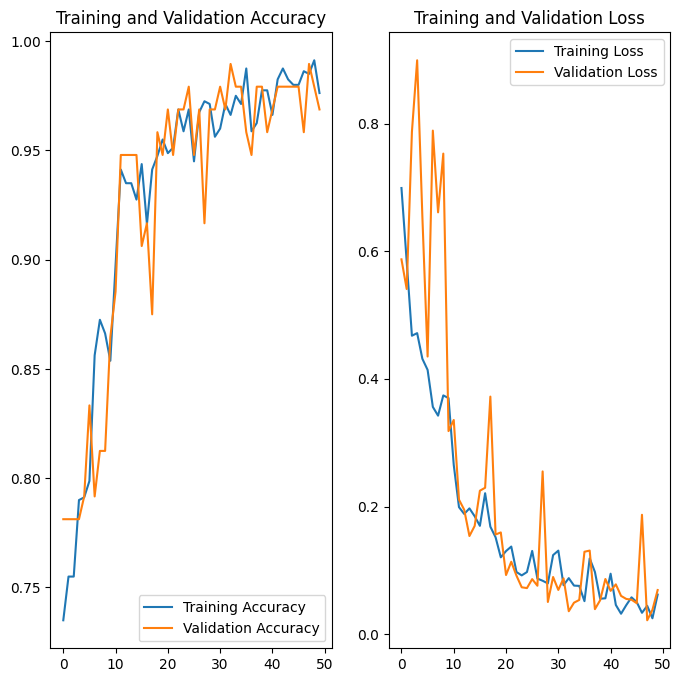

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato__Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato__Late_blight


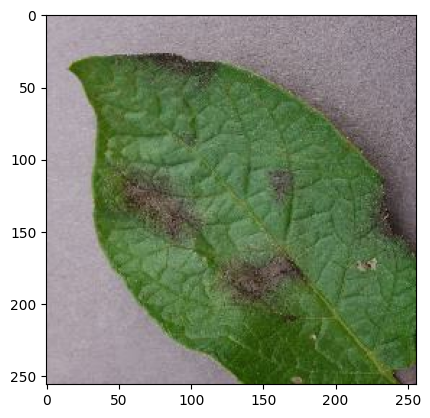

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 84ms/step


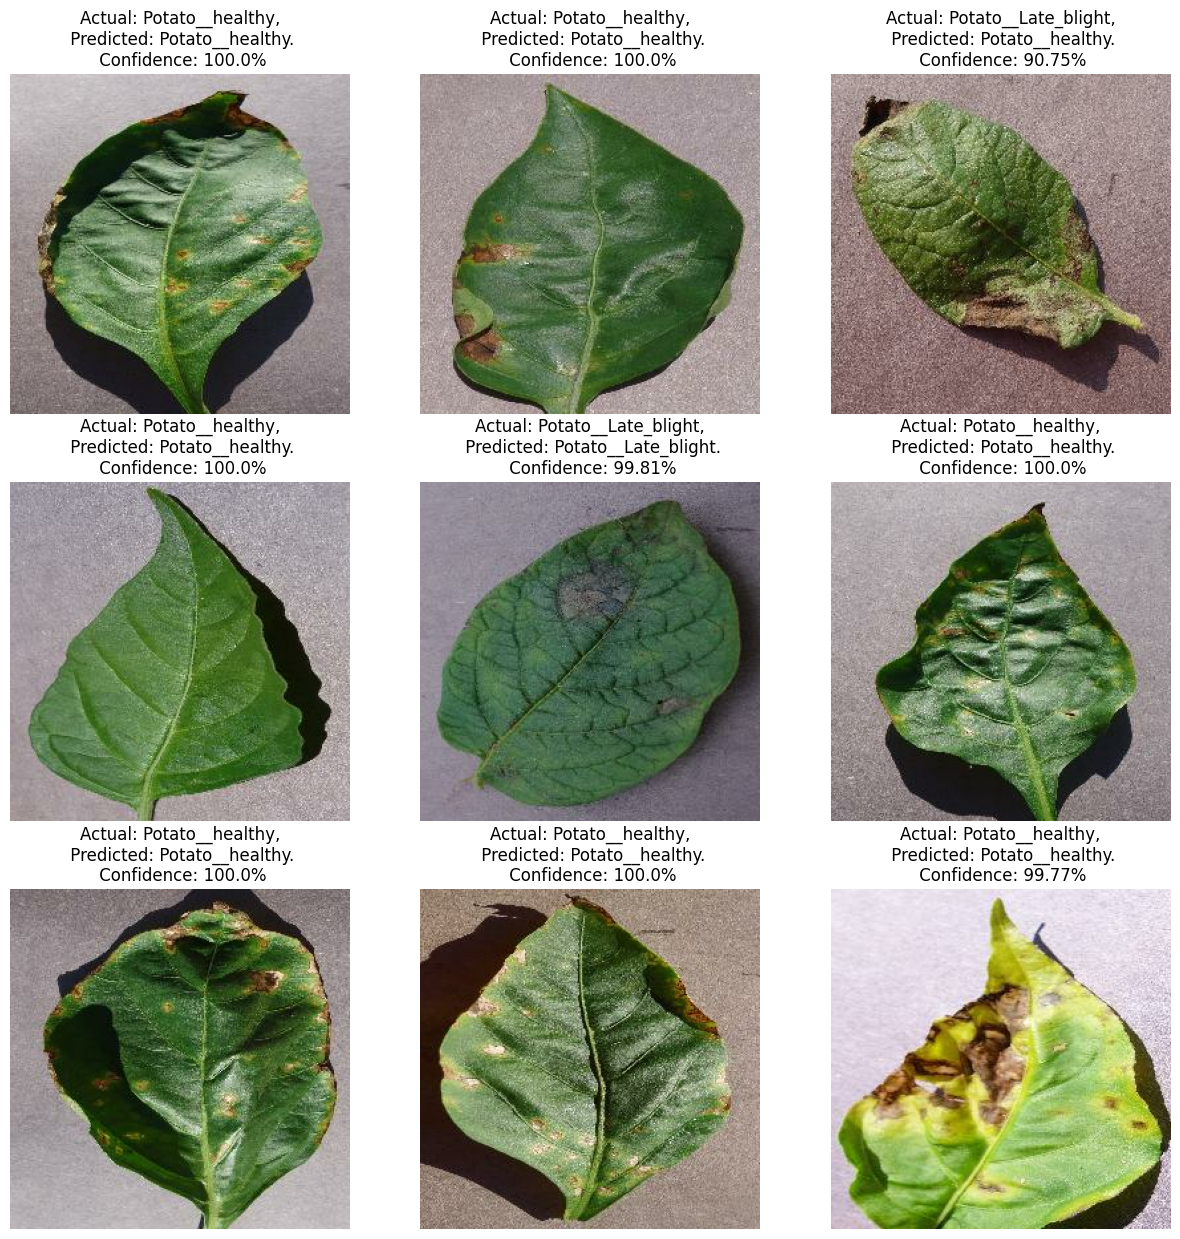

In [67]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [82]:
import os

file_path = 'potatoes.tflite.txt'
directory_path = 'potatoes.tflite'

# Check if the file exists
if os.path.isfile(file_path):
    # Rename the file (optional step)
    os.rename(file_path, file_path + '_old')

    # Or remove the file
    os.remove(file_path)

# Create the directory
if not os.path.exists(directory_path):
    os.makedirs(directory_path)


In [83]:
import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save("/content/potatoes.tflite")

In [84]:
model.save("../potatoes.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
model = tf.keras.models.load_model("../potatoes.h5")

In [86]:
# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [88]:
# Save the TFLite model to a file
with open("potatoes.tflite_old", "wb") as f:
    f.write(tflite_model)

In [89]:
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    return interpreter, input_details, output_details

In [92]:
load_tflite_model("/content/potatoes.tflite_old")

(<tensorflow.lite.python.interpreter.Interpreter at 0x7b841fbfa140>,
 [{'name': 'serving_default_sequential_input:0',
   'index': 0,
   'shape': array([  1, 256, 256,   3], dtype=int32),
   'shape_signature': array([ -1, 256, 256,   3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'StatefulPartitionedCall:0',
   'index': 35,
   'shape': array([1, 3], dtype=int32),
   'shape_signature': array([-1,  3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}])

In [93]:
def predict_tflite(interpreter, input_details, output_details, img):
    # Convert the input image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add a batch dimension to the image (expected by the model)
    input_data = np.expand_dims(img_array, axis=0)

    # Set the input tensor to the input data
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the index of the predicted class (class with highest probability)
    predicted_class_index = np.argmax(output_data)

    # Assuming 'class_names' is a list of class labels corresponding to the model's output
    # Example: class_names = ['class1', 'class2', 'class3', ...]
    class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
    predicted_class = class_names[predicted_class_index]

    # Calculate the confidence score (probability of the predicted class)
    confidence = round(100 * np.max(output_data), 2)

    return predicted_class, confidence

In [94]:
def showImage(imageName):
    image_path = imageName
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()

In [104]:
tflite_model_path = "/content/potatoes.tflite_old"
interpreter, input_details, output_details = load_tflite_model(tflite_model_path)

# Now you can use the predict_tflite function with the loaded TFLite model
# For example, to predict an image named 'your_image.jpg':
image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/PlantVillage/th (1).jpeg', target_size=(256, 256))
predicted_class, confidence = predict_tflite(interpreter, input_details, output_details, image)

print("Predicted Class:", predicted_class)
print("Confidence:", confidence)

Predicted Class: Potato___Early_blight
Confidence: 93.23


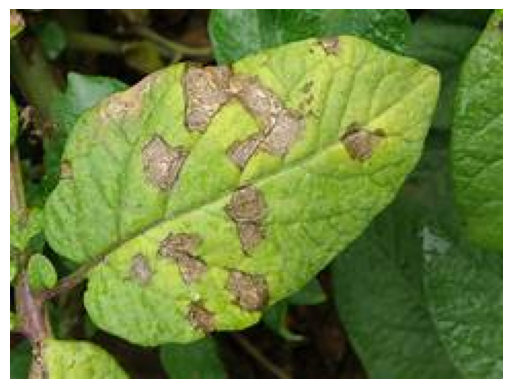

Predicted Class: Potato___Early_blight
Confidence: 93.23


In [105]:
showImage("/content/drive/MyDrive/PlantVillage/th (1).jpeg")
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)